# Julia Deep Learning

https://fluxml.ai/

https://github.com/FluxML/model-zoo

In [1]:
using Flux
using CuArrays
using Plots
using Plots.PlotMeasures

CuArrays.allowscalar(false)

pyplot()

┌ Warning: Incompatibility detected between CUDA and LLVM 8.0+; disabling debug info emission for CUDA kernels
└ @ CUDAnative /home/cavani/Workspace/julia-abc/software/julia-env/packages/CUDAnative/hfulr/src/CUDAnative.jl:114


Plots.PyPlotBackend()

## MNIST Dataset

In [2]:
function load_mnist(split_name)
    mnist = Flux.Data.MNIST
    
    images = mnist.images(split_name) # Array with N images of 28x28 8-bits gray
    labels = mnist.labels(split_name) # Array with N labels scalar 0-9
    
    return (images=images, labels=labels)
end

train_data = load_mnist(:train)
test_data = load_mnist(:test)

println("Train images:\n",
        "\ntype = ", typeof(train_data.images),
        "\nsize = ", size(train_data.images),
        "\nshape = ", size(train_data.images[1]),
        "\n")
println("Train labels:\n",
        "\ntype = ", typeof(train_data.labels),
        "\nsize = ", size(train_data.labels),
        "\n")
println("Test images:\n",
        "\ntype = ", typeof(test_data.images),
        "\nsize = ", size(test_data.images),
        "\nshape = ", size(test_data.images[1]),
        "\n")
println("Test labels:\n",
        "\ntype = ", typeof(test_data.labels),
        "\nsize = ", size(test_data.labels))

Train images:

type = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
size = (60000,)
shape = (28, 28)

Train labels:

type = Array{Int64,1}
size = (60000,)

Test images:

type = Array{Array{Gray{FixedPointNumbers.Normed{UInt8,8}},2},1}
size = (10000,)
shape = (28, 28)

Test labels:

type = Array{Int64,1}
size = (10000,)


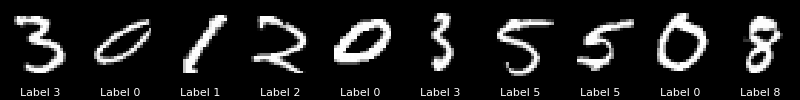

In [3]:
plot_digit(image, label) = plot(image, xlabel=(label !== nothing ? "Label $(label)" : ""),
                                guidefontsize=8, legend=false, margin=0mm, link=:both,
                                ticks=nothing, border=:none)
function plot_digits(images, labels=nothing; size=(800, 100), layout=(1, length(images)))
    plots = map(1:prod(layout)) do i
        image = images[i]
        label = labels !== nothing ? labels[i] : nothing
        plot_digit(image, label)
    end
    plot(plots..., layout=layout, size=size, bg_color="black", fg_color="white")
end

function sample(data, size=10)
    indices = rand(1:length(data.images), 10)
    images = data.images[indices]
    labels = data.labels[indices]
    return (images=images, labels=labels)
end

train_sample = sample(train_data)
plot_digits(train_sample...)

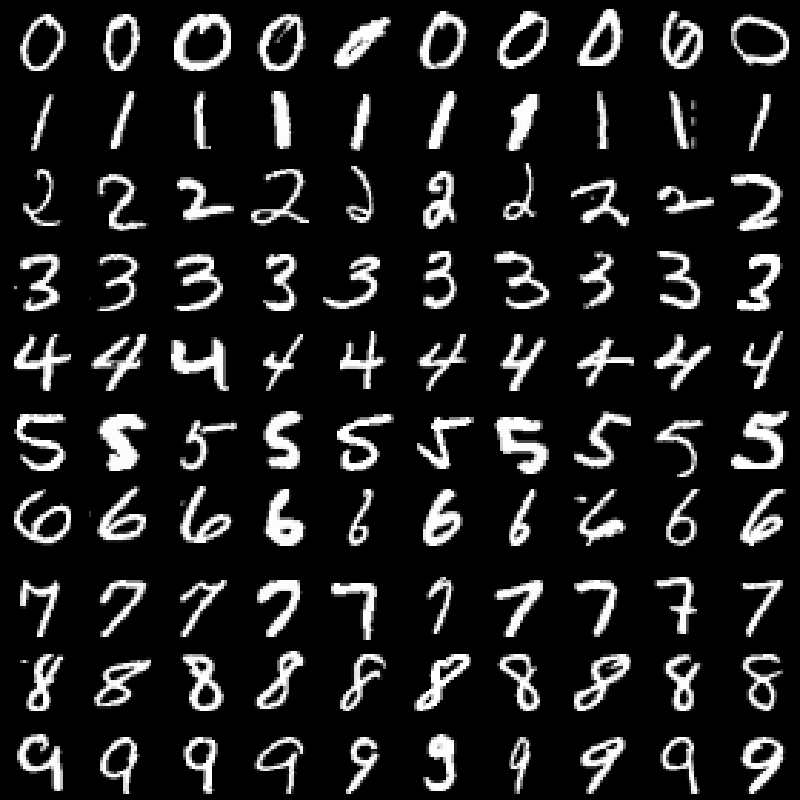

In [4]:
function sample_classes(data, sample_size_per_class=10)
    class_vector = sort(unique(data.labels))
    samples = map(class_vector) do label
        label_indices = findall(==(label), data.labels)
        sample_indices = rand(label_indices, sample_size_per_class)
        images = data.images[sample_indices]
        images
    end
    return samples
end

train_sample2 = sample_classes(train_data)
plot_digits(vcat(train_sample2...); size=(800, 800), layout=(10, 10))

In [5]:
function compute_num_channels(image)
    color_type = eltype(image)
    if color_type <: Gray
        return 1
    elseif color_type <: RGB
        return 3
    else
        error("Unknown color type: $(color_type)")
    end
end

function make_whcn_format(images)
    width, height = size(images[1])
    num_channels = compute_num_channels(images[1])
    batch_size = length(images)
    @assert num_channels == 1 # only Gray -> Foloat32 supported

    images_tensor = Array{Float32, 4}(undef, width, height, num_channels, batch_size)
    for (batch_index, image) in enumerate(images)
        images_tensor[:, :, :, batch_index] = Float32.(reshape(image, width, height, num_channels))
    end
    return images_tensor
end

X_whcn = make_whcn_format(train_sample.images)
println("X (WHCN format):\n",
        "\ntype = ", typeof(X_whcn),
        "\nsize = ", size(X_whcn))

X (WHCN format):

type = Array{Float32,4}
size = (28, 28, 1, 10)


In [6]:
import Flux: onehot

function make_onehot_format(labels, class_vector)
    num_labels = length(class_vector)
    batch_size = length(labels)
    
    labels_tensor = Array{Float32, 2}(undef, num_labels, batch_size)
    for (batch_index, label) in enumerate(labels)
        labels_tensor[:, batch_index] = Float32.(onehot(label, class_vector))
    end
    return labels_tensor
end

y_onehot = make_onehot_format(train_sample.labels, 0:9)
println("y (One Hot format):\n",
        "\ntype = ", typeof(y_onehot),
        "\nsize = ", size(y_onehot))

y (One Hot format):

type = Array{Float32,2}
size = (10, 10)


In [7]:
import Base.Iterators: partition

function make_batch(images, labels)
    X = make_whcn_format(images)
    y = make_onehot_format(labels, 0:9)
    return (X=X, y=y)
end

function make_dataset(images, labels; batch_size)
    batch_size == 0 && return make_batch(images, labels)
    
    num_examples = length(images)
    num_batches = ceil(Int, num_examples / batch_size)
    batch_indices = partition(1:num_examples, batch_size)
    batches = map(batch_indices) do indices
        make_batch(images[indices], labels[indices])
    end
    return batches
end

dataset_train = make_dataset(train_data...; batch_size=256)
dataset_test = make_dataset(test_data...; batch_size=0)

println("Train\n")
println("Number of batches   : ", length(dataset_train))
println("First batch X shape : ", size(dataset_train[1].X))
println("First batch y shape : ", size(dataset_train[1].y))
println("Last batch X shape  : ", size(dataset_train[end].X))
println("Last batch y shape  : ", size(dataset_train[end].y))
println()
println("Test\n")
println("X shape             : ", size(dataset_test.X))
println("y shape             : ", size(dataset_test.y))

Train

Number of batches   : 235
First batch X shape : (28, 28, 1, 256)
First batch y shape : (10, 256)
Last batch X shape  : (28, 28, 1, 96)
Last batch y shape  : (10, 96)

Test

X shape             : (28, 28, 1, 10000)
y shape             : (10, 10000)


## More API

In [8]:
flatten(x) = reshape(x, :, size(x)[end])

struct Reshape
    dims
end

(layer::Reshape)(x) = reshape(x, layer.dims..., size(x)[end])

In [9]:
import Flux: train!
import BSON: bson, load
import Printf: @printf

bind_model(f, model) = (args...) -> f(model, args...)

function run_train(model, train_data, eval_data;
                   loss, metric,
                   optimizer=ADAM(0.001),
                   num_epochs=100,
                   early_stopping_mode=:max,
                   early_stopping_target=nothing,
                   early_stopping_patience=10,
                   learning_rate_schedule=5,
                   model_file="model.bson")
    if early_stopping_mode == :max
        better_metric = ≥
    elseif early_stopping_mode == :min
        better_metric = ≤
    else
        error("early_stopping_mode unknown: $early_stopping_mode")
    end
    compute_loss = bind_model(loss, model)
    compute_metric = bind_model(metric.fn, model)
    best_metric = nothing
    last_improvement = 0
    for epoch_idx in 1:num_epochs
        # Train for a single epoch
        for i in 1:length(train_data)
            let data = gpu(train_data[i])
                train!(compute_loss, params(model), [data], optimizer)
            end
        end

        # Calculate metric:
        metric_eval = let data = gpu(eval_data)
            compute_metric(data...)
        end

        @printf("[%d] Eval %s: %.4f\n", epoch_idx, metric.name, metric_eval)

        # If our metric is good enough, quit out.
        if early_stopping_target !== nothing && better_metric(metric_eval, early_stopping_target)
            println(" -> Early-exiting: We reached our target $(metric.name) of $early_stopping_target")
            break
        end

        # If this is the best metric we've seen so far, save the model out
        if best_metric === nothing || better_metric(metric_eval, best_metric)
            println(" -> New best $(metric.name)! Saving model out to $(model_file)")
            bson(model_file, model = cpu(model), epoch = epoch_idx, metric = metric_eval)
            best_metric = metric_eval
            last_improvement = epoch_idx
        end

        # If we haven't seen improvement in N epochs, drop our learning rate:
        if epoch_idx - last_improvement >= learning_rate_schedule && optimizer.eta > 1e-6
            optimizer.eta /= 10.0
            println(" -> Haven't improved in a while, dropping learning rate to $(optimizer.eta)!")

            # After dropping learning rate, give it a few epochs to improve
            last_improvement = epoch_idx
        end

        if epoch_idx - last_improvement >= early_stopping_patience
            println(" -> We're calling this converged.")
            break
        end
    end
end

function load_model(model_file; use_gpu=true)
    model = load(model_file)[:model]
    if use_gpu
        model = gpu(model)
    end
    return model
end

function evaluate(model, eval_data; metrics)
    data = gpu(eval_data)

    println("Evaluation\n")
    
    for metric in metrics
        compute_metric = bind_model(metric.fn, model)
        metric_eval = compute_metric(data...)
        println(rpad(metric.name, 10), " : ", metric_eval)
    end
end

evaluate (generic function with 1 method)

In [10]:
import Flux: logitcrossentropy, onecold
import Statistics: mean

function crossentropy(model, x, y)
    logits = model[1:end-1](x)
    return logitcrossentropy(logits, y)
end

function crossentropy_noise(model, x, y)
    x_aug = x .+ 0.1f0 * gpu(randn(eltype(x), size(x)))
    logits = model[1:end-1](x)
    return logitcrossentropy(logits, y)
end

function mse(model, x, y)
    ŷ = model(x)
    err = ŷ .- y
    N = length(x)
    return sum(err .* err) / N
end

function accuracy(model, x, y)
    ŷ = model(x)
    return mean(onecold(cpu(ŷ)) .== onecold(cpu(y)))
end

accuracy (generic function with 1 method)

## CNN

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/conv.jl

In [11]:
function make_cnn(input_shape, output_size; use_gpu=true)
    fc_size = (input_shape.width ÷ 2 ÷ 2 ÷ 2) * (input_shape.height ÷ 2 ÷ 2 ÷ 2) * 32

    model = Chain(
        Conv((3, 3), input_shape.num_channels => 16, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 16 => 32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        Conv((3, 3), 32 => 32, pad=(1, 1), relu),
        MaxPool((2, 2)),

        flatten,
        Dense(fc_size, output_size),
        softmax
    )

    if use_gpu
        model = gpu(model)
    end
    
    return model
end

cnn_input_shape = (width=28, height=28, num_channels=1)
cnn_output_size = 10 # 0-9

cnn = make_cnn(cnn_input_shape, cnn_output_size)

Chain(Conv((3, 3), 1=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dense(288, 10), softmax)

In [12]:
X1, y1 = gpu(dataset_train[1])
ŷ1 = cnn(X1)

10×256 CuArray{Float32,2,Nothing}:
 0.113566   0.117945   0.125453   …  0.118663   0.115619   0.109576
 0.124866   0.12916    0.124572      0.13121    0.126092   0.128217
 0.0879997  0.0889619  0.0879535     0.0825403  0.0850113  0.0870321
 0.081747   0.0852816  0.0899764     0.084147   0.0895893  0.0820491
 0.091503   0.0857015  0.0819831     0.0935777  0.0894472  0.088383
 0.102619   0.106225   0.107315   …  0.105273   0.110875   0.111991
 0.109906   0.0995755  0.10559       0.0991628  0.103934   0.107691
 0.0825801  0.0850953  0.0870238     0.0823588  0.0859608  0.0836697
 0.109506   0.107786   0.101849      0.110168   0.104427   0.111203
 0.0957077  0.0942683  0.0882844     0.0928996  0.089044   0.0901877

In [13]:
loss_train = crossentropy_noise(cnn, X1, y1)
metric_train = accuracy(cnn, X1, y1)

println("Train (batch 1)\n")    
println("Loss     : ", loss_train)
println("Accuracy : ", metric_train)

Train (batch 1)

Loss     : 2.3202488
Accuracy : 0.08203125


In [14]:
run_train(cnn, dataset_train, dataset_test;
          loss=crossentropy_noise,
          metric=(name="Accuracy", fn=accuracy),
          model_file="cnn_mnist.bson")

[1] Eval Accuracy: 0.9526
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[2] Eval Accuracy: 0.9703
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[3] Eval Accuracy: 0.9756
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[4] Eval Accuracy: 0.9805
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[5] Eval Accuracy: 0.9836
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[6] Eval Accuracy: 0.9845
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[7] Eval Accuracy: 0.9859
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[8] Eval Accuracy: 0.9860
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[9] Eval Accuracy: 0.9866
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[10] Eval Accuracy: 0.9873
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[11] Eval Accuracy: 0.9874
 -> New best Accuracy! Saving model out to cnn_mnist.bson
[12] Eval Accuracy: 0.9875
 -> New best Accuracy! Saving model out to cnn_

In [15]:
best_cnn = load_model("cnn_mnist.bson")
evaluate(best_cnn, dataset_test;
         metrics=[(name="Loss", fn=crossentropy_noise), (name="Accuracy", fn=accuracy)])

Evaluation

Loss       : 0.035840504
Accuracy   : 0.9904


In [16]:
best_cnn = nothing
cnn = nothing
X1 = nothing
y1 = nothing
ŷ1 = nothing
GC.gc()

## MLP

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/mlp.jl

In [17]:
function make_mlp(input_size, output_size, hidden_size; use_gpu=true)
    model = Chain(
        flatten,
        Dense(input_size, hidden_size, relu),
        Dense(hidden_size, output_size),
        softmax
    )
    if use_gpu
        model = gpu(model)
    end
    return model
end

mlp_input_size = 28 * 28 * 1 # w * h * #c
mlp_output_size = 10 # 0-9
mlp_hidden_size = 500

mlp = make_mlp(mlp_input_size, mlp_output_size, mlp_hidden_size)

Chain(flatten, Dense(784, 500, relu), Dense(500, 10), softmax)

In [18]:
X1, y1 = gpu(dataset_train[1])
ŷ1 = mlp(X1)

10×256 CuArray{Float32,2,Nothing}:
 0.0628723  0.0604572  0.066718   …  0.0565594  0.0567863  0.0476956
 0.173905   0.191462   0.129736      0.148237   0.135498   0.150506
 0.0981704  0.073239   0.0907614     0.0671934  0.0994514  0.0614186
 0.0930456  0.101801   0.0669573     0.0911262  0.0583314  0.0745883
 0.0776217  0.132306   0.0889338     0.131488   0.0871561  0.102899
 0.0875327  0.0984666  0.152805   …  0.0943448  0.113125   0.121152
 0.121246   0.0981212  0.0920314     0.102166   0.132651   0.17305
 0.095108   0.0670292  0.103747      0.0821553  0.119238   0.0584762
 0.0885674  0.0763189  0.0969549     0.126857   0.109342   0.132304
 0.101931   0.100798   0.111355      0.0998729  0.088421   0.07791

In [19]:
loss_train = crossentropy(mlp, X1, y1)
metric_train = accuracy(mlp, X1, y1)

println("Train (batch 1)\n")    
println("Loss     : ", loss_train)
println("Accuracy : ", metric_train)

Train (batch 1)

Loss     : 2.3654654
Accuracy : 0.07421875


In [20]:
run_train(mlp, dataset_train, dataset_test;
          loss=crossentropy,
          metric=(name="Accuracy", fn=accuracy),
          model_file="mlp_mnist.bson")

[1] Eval Accuracy: 0.9511
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[2] Eval Accuracy: 0.9642
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[3] Eval Accuracy: 0.9696
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[4] Eval Accuracy: 0.9719
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[5] Eval Accuracy: 0.9729
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[6] Eval Accuracy: 0.9736
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[7] Eval Accuracy: 0.9741
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[8] Eval Accuracy: 0.9750
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[9] Eval Accuracy: 0.9761
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[10] Eval Accuracy: 0.9769
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[11] Eval Accuracy: 0.9773
 -> New best Accuracy! Saving model out to mlp_mnist.bson
[12] Eval Accuracy: 0.9780
 -> New best Accuracy! Saving model out to mlp_

In [21]:
best_mlp = load_model("mlp_mnist.bson")
evaluate(best_mlp, dataset_test;
         metrics=[(name="Loss", fn=crossentropy), (name="Accuracy", fn=accuracy)])

Evaluation

Loss       : 0.065908626
Accuracy   : 0.9847


In [22]:
best_mlp = nothing
mlp = nothing
X1 = nothing
y1 = nothing
ŷ1 = nothing
GC.gc()

## Autoencoder

https://github.com/FluxML/model-zoo/blob/master/vision/mnist/autoencoder.jl

In [23]:
function make_autoencoder(input_shape, hidden_size, encoded_size; use_gpu=true)
    encoder = Chain(
        flatten,
        Dense(prod(input_shape), hidden_size, leakyrelu),
        Dense(hidden_size, encoded_size, leakyrelu),
    )

    decoder = Chain(
        Dense(encoded_size, hidden_size, leakyrelu),
        Dense(hidden_size, prod(input_shape), leakyrelu),
        Reshape(input_shape),
    )

    model = Chain(encoder, decoder)

    if use_gpu
        model = gpu(model)
    end
    
    return model
end

ae_input_shape = (28, 28, 1)
ae_hidden_size = 500
ae_encoded_size = 50

autoencoder = make_autoencoder(ae_input_shape, ae_hidden_size, ae_encoded_size)

Chain(Chain(flatten, Dense(784, 500, leakyrelu), Dense(500, 50, leakyrelu)), Chain(Dense(50, 500, leakyrelu), Dense(500, 784, leakyrelu), Reshape((28, 28, 1))))

In [24]:
x1 = gpu(dataset_train[1].X)
x̂1 = autoencoder(x1)
println("x : type=$(typeof(x1)), size=$(size(x1))")
println("x̂ : type=$(typeof(x̂1)), size=$(size(x̂1))")

x : type=CuArray{Float32,4,Nothing}, size=(28, 28, 1, 256)
x̂ : type=CuArray{Float32,4,CuArray{Float32,2,Nothing}}, size=(28, 28, 1, 256)


In [25]:
autoencoder_mse(model, x) = mse(model, x, x)

loss_train = autoencoder_mse(autoencoder, x1)

println("Train (batch 1)\n")    
println("Loss     : ", loss_train)

Train (batch 1)

Loss     : 0.10538794


In [26]:
dataset2_train = [(X=X,) for (X, _) in dataset_train]
dataset2_test = (X=dataset_test.X,)

println("Train\n")
println("Number of batches   : ", length(dataset2_train))
println("First batch X shape : ", size(dataset2_train[1].X))
println("Last batch X shape  : ", size(dataset2_train[end].X))
println()
println("Test\n")
println("X shape             : ", size(dataset2_test.X))

Train

Number of batches   : 235
First batch X shape : (28, 28, 1, 256)
Last batch X shape  : (28, 28, 1, 96)

Test

X shape             : (28, 28, 1, 10000)


In [27]:
run_train(autoencoder, dataset2_train, dataset2_test;
          loss=autoencoder_mse,
          metric=(name="MSE", fn=autoencoder_mse),
          early_stopping_mode=:min,
          model_file="ae_mnist.bson")

[1] Eval MSE: 0.0128
 -> New best MSE! Saving model out to ae_mnist.bson
[2] Eval MSE: 0.0097
 -> New best MSE! Saving model out to ae_mnist.bson
[3] Eval MSE: 0.0087
 -> New best MSE! Saving model out to ae_mnist.bson
[4] Eval MSE: 0.0080
 -> New best MSE! Saving model out to ae_mnist.bson
[5] Eval MSE: 0.0077
 -> New best MSE! Saving model out to ae_mnist.bson
[6] Eval MSE: 0.0075
 -> New best MSE! Saving model out to ae_mnist.bson
[7] Eval MSE: 0.0071
 -> New best MSE! Saving model out to ae_mnist.bson
[8] Eval MSE: 0.0070
 -> New best MSE! Saving model out to ae_mnist.bson
[9] Eval MSE: 0.0067
 -> New best MSE! Saving model out to ae_mnist.bson
[10] Eval MSE: 0.0064
 -> New best MSE! Saving model out to ae_mnist.bson
[11] Eval MSE: 0.0063
 -> New best MSE! Saving model out to ae_mnist.bson
[12] Eval MSE: 0.0062
 -> New best MSE! Saving model out to ae_mnist.bson
[13] Eval MSE: 0.0060
 -> New best MSE! Saving model out to ae_mnist.bson
[14] Eval MSE: 0.0059
 -> New best MSE! Saving 

In [28]:
best_autoencoder = load_model("ae_mnist.bson")
evaluate(best_autoencoder, dataset2_test;
         metrics=[(name="Loss", fn=autoencoder_mse)])

Evaluation

Loss       : 0.0038435622


In [29]:
best_autoencoder = nothing
autoencoder = nothing
x1 = nothing
x̂1 = nothing
GC.gc()